# scGen: a landmark generative model for unseen perturbations
---

## 1. Introduction

Single-cell RNA-sequencing (scRNA-seq) has made it possible to measure how thousands of individual cells change their transcriptional programs in response to genetic, chemical, or environmental **perturbations**. However, performing every possible perturbation in the wet lab is infeasible; the search space explodes combinatorially, and many experiments are costly or technically difficult. **Perturbation‐response models** (such as **scGen**) aim to fill this gap by *predicting* how an unobserved condition would rewrite the transcriptome, given (i) gene-expression data from control cells and (ii) knowledge of a related perturbation.  

[**scGen**](https://github.com/theislab/scgen) first compresses every cell’s high-dimensional count vector into a handful of latent “coordinates” using a variational auto-encoder (VAE). Because the VAE is trained on both control and stimulated cells, the latent space ends up organised so that “IFN-β vs control” is almost a straight line. Once the model has that line it can:
- Learn a single “perturbation vector” δ (the average shift from control) → IFN-β in the latent space.
- Add δ to any other control cell, even one it never saw in training (e.g. a held-out CD4 T cell), and decode the point back to gene space to get a de-novo prediction of the stimulated transcriptome.
- Generalise across cell types, studies and even species.

The goal of this notebook is therefore two-fold:
1. **Methodological** – demonstrate a **reproducible benchmarking pipeline** for scGen using the Perturb-Bench toolbox.  
2. **Practical** – show you how to inspect and interpret scGen’s predictions with both **statistical metrics** and **biological read-outs**.

---

### 1.1.  Why use the [*Kang 2018*](https://figshare.com/articles/dataset/Kang_HM_Subramaniam_M_Targ_S_Nguyen_M_et_al_2017/19397624?file=34464122) dataset?  

* **Clean control vs IFN-β stimulation** on human PBMCs (peripheral blood mononuclear cells), generated with a 6-hour cytokine pulse that elicits a strong innate-immune transcriptional response.
* **Moderate size (~25 k cells × 15 k genes)** - big enough to show realistic heterogeneity yet small enough to train scGen in minutes on a laptop CPU.
* **Rich cell-type annotation** (CD4 T, CD8 T, NK, monocytes, B cells, dendritic cells, …) enables plug-and-play experiments with any lineage.
* **Widely used benchmark** in perturbation-response papers (including the original scGen study), so results are easy to compare with the literature.
---

### 1.2.  Overview of the notebook

In this hands‑on notebook you will:

1. **Load & explore** the *Kang 2018* single‑cell PBMC dataset (control vs IFN‑β).  
2. **Prepare** the data → QC, log‑normalise, select 2,000 highly‑variable genes.  
3. **Train scGen** holding out the stimulated CD4 T cells.  
4. **Evaluate** predictions with a variety of meaningful metrics:  
    - $R^2$ on log‑counts  
    - bulk distance measures  
    - overlap of the top‑100 differentially‑expressed genes (DEGs).  
5. **Plug‑&‑play**: rerun the same pipeline for *any* other cell type via a drop‑down.  
6. **Cross-study extrapolation**: use the trained model to predict IFN-β responses in a different dataset.

Let’s jump in!

---

## 2. Environment Setup & Imports

In [ ]:
# --- Standard-library utilities ------------------------------------------------
import os                 # file-system operations (e.g. os.environ or os.path)
import sys                # Python runtime details; we use it for version checks
import time               # simple timing / benchmarking of cells
from pathlib import Path  # convenient, cross-platform path handling
from collections import OrderedDict  # deterministic dicts for reproducible logs
import random             # Python RNG (seeded below for reproducibility)
import warnings           # warning control (e.g. to suppress scVI warnings)
warnings.filterwarnings('ignore')  # suppress warnings (e.g. from scVI or scanpy)

# --- Numerical & data-handling stack -------------------------------------------
import numpy as np        # dense numerical arrays
import pandas as pd       # tabular data frames
from pandas.api.types import CategoricalDtype  # categorical data types
from scipy import sparse  # sparse matrix utilities
from scipy import stats   # statistical functions (e.g. t-tests, correlations)
from scipy.spatial.distance import cosine as cosine_dist, cdist  # distance metrics
from scipy.sparse import issparse  # check if a matrix is sparse

# --- Single-cell analysis ecosystem --------------------------------------------
import scanpy as sc       # core single-cell workflow (AnnData, QC, plotting)
from scanpy.pl import DotPlot # dot plots for visualising gene expression
import anndata            # core data structure for single-cell data (AnnData)
import pertpy as pt       # Perturb-Bench helpers: dataset loaders & metrics
import scvi               # single-cell variational inference (scVI) for deep learning
from scvi import REGISTRY_KEYS  # keys used by scvi-tools / scGen for AnnData metadata

# --- Deep-learning backend -----------------------------------------------------
import torch                    # PyTorch (Tensor operations)
import pytorch_lightning as pl  # PyTorch Lightning (high-level training framework)

# --- Machine-learning utilities ------------------------------------------------
from sklearn.decomposition import PCA                # dimensionality reduction
from sklearn.neighbors import KernelDensity          # density estimation
from sklearn.metrics import r2_score                 # R-squared metric
from sklearn.metrics import pairwise_distances       # pairwise distance metrics

# --- Plotting & visualisation --------------------------------------------------
import matplotlib.pyplot as plt  # base plotting library
import matplotlib as mpl         # base matplotlib library
import seaborn as sns            # higher-level statistical plots

# --- Device & runtime configuration --------------------------------------------
# check if cuda exists
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Running on 'CUDA' with {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available, running on CPU")

# --- Miscellaneous settings ----------------------------------------------------
import ipywidgets as widgets # interactive widgets for Jupyter notebooks

# --- Global reproducibility ----------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True   # exact determinism (may reduce speed)
torch.backends.cudnn.benchmark = False
pl.seed_everything(SEED, workers=True)
scvi.settings.seed = SEED 

print(f"Random seed set to {SEED}")

Seed set to 42
Seed set to 42


Running on'CPU'
Random seed set to 42


In [2]:
# check if cuda exists
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Running on 'CUDA' with {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available, running on CPU")

Running on 'CUDA' with NVIDIA GeForce RTX 4070 Laptop GPU


---

## 3. Data Exploration & Preparation

### 3.1. Loading and Exploring the *Kang 2018* dataset

We begin by loading the *Kang 2018* dataset that will be used throughout this notebook.

In [3]:
# adata = pt.dt.kang_2018() # downloading the Kang 2018 dataset
adata = sc.read('../data/kang_2018.h5ad') # loading the data directly from the file

adata # viewing the data

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

[`AnnData`](https://anndata.readthedocs.io/) is the de-facto container for single-cell data in Python (used by **Scanpy**, **scvi-tools**, **Perturb-Bench**, and many other packages). Think of it as a tidy “Excel workbook” with one big table of gene expression and several *linked* annotation sheets:

| Attribute | Purpose | In **Kang 2018 PBMC** |
|-----------|---------|-----------------------|
| **`.X`** *(n_obs × n_vars)* | The main numerical matrix – usually raw counts, log-counts, or latent embeddings. Rows = **cells** (*observations*), columns = **genes** (*variables*). | **24,673 cells** × **15,706 genes** (raw counts; we’ll log-normalise below). |
| **`.obs`** | Per-cell metadata (`pandas.DataFrame`). | 12 columns – e.g. `cell_type`, `label` (*ctrl* / *stim*), `replicate`, t-SNE coordinates. |
| **`.var`** | Per-gene metadata. | A single column `name` (Ensembl IDs). |
| **`.layers`** | Alternative expressions of `.X` (e.g. raw counts, denoised counts, predictions). | Empty for now (can contain layers like `log_norm` or `pred`) |
| **`.uns`** | Unstructured auxiliary info (colour maps, settings, model fits). | Currently empty; Scanpy will store `log1p` and plotting settings here. |
| **`.obsm` / `.varm`** | Multi-dimensional annotations (matrices): embeddings, feature scores. | `X_pca` (50-D PCA) and `X_umap` (2-D UMAP). |
| **`.obsp` / `.varp`** | Pairwise matrices (graphs, distances). | Not present yet – we could add neighbourhood graphs after QC. |

In [4]:
# OPTIONAL DOWNSAMPLING IN CASE THE CODE RUNS FOR TOO LONG OR THE KERNEL CRASHES
# Uncomment the following lines to downsample the dataset to a manageable size.

# # --- parameters ----------------------------------------------------
# TARGET_N    = 12_000          # final cell count  (≈ half of the original 24 673)
# STRAT_COL   = "cell_type"     # column in adata.obs that holds the cell labels

# # --- subsample -----------------------------------------------------

# # 1) work out how many cells to keep per type  (rounded, but never > available)
# obs_counts   = adata.obs[STRAT_COL].value_counts()
# proportions  = (obs_counts / obs_counts.sum())
# target_per   = (proportions * TARGET_N).round(0).astype(int)

# # 2) take random rows per stratum
# keep_idx = []
# for label, n_keep in target_per.items():
#     pool = adata.obs_names[adata.obs[STRAT_COL] == label]
#     n_keep = min(n_keep, len(pool))          # guard against rare rounding overflow
#     keep_idx.extend(np.random.choice(pool, n_keep, replace=False))

# # 3) subset + report
# adata = adata[keep_idx].copy()
# print(f"Down-sampled to {adata.n_obs:,} cells "
#       f"({len(obs_counts)} cell types, same distribution).")

We rename `label` to `condition` and the conditions themselves for improved readability.

In [5]:
adata.obs.rename(columns={"label": "condition"}, inplace=True) # renaming the 'label' column to 'condition'

# Renaming the categories in the 'condition' column
if isinstance(adata.obs["condition"].dtype, CategoricalDtype):
    adata.obs["condition"] = (
        adata.obs["condition"]
        .cat.rename_categories({"ctrl": "control", "stim": "stimulated"})
    )
else:
    adata.obs["condition"] = (
        adata.obs["condition"]
        .map({"ctrl": "control", "stim": "stimulated"})
        .astype("category")
    )

In [6]:
adata # viewing the data again after renaming

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [7]:
adata.obs.head(10)  # viewing the first 10 rows of the observation metadata (cell-level)

,nCount_RNA,nFeature_RNA,tsne1,tsne2,condition,cluster,cell_type,replicate,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters
index,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,control,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,control,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,control,3,CD4 T cells,patient_1488,908.0,337,6,6
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,control,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,control,4,Dendritic cells,patient_1039,1857.0,928,12,12
AAACATACGATGAA-1,1869.0,635,-0.470236,-25.398709,control,5,CD4 T cells,patient_1488,1525.0,634,2,2
AAACATACGCCAAT-1,1142.0,436,-15.906183,20.085315,control,9,CD14+ Monocytes,patient_1016,1157.0,436,1,1
AAACATACGCTTCC-1,817.0,427,-6.740394,-23.932985,control,5,CD4 T cells,patient_1256,961.0,427,0,0
AAACATACGGCATT-1,1582.0,558,-17.682803,21.005576,control,9,CD14+ Monocytes,patient_1015,1397.0,557,1,1


In [8]:
adata.var.head(10)  # viewing the first 10 rows of the variable metadata (gene-level)

,name
index,
AL627309.1,AL627309.1
RP11-206L10.2,RP11-206L10.2
RP11-206L10.9,RP11-206L10.9
FAM87B,FAM87B
LINC00115,LINC00115
FAM41C,FAM41C
NOC2L,NOC2L
KLHL17,KLHL17
PLEKHN1,PLEKHN1


In [9]:
display(adata.obs['condition'].value_counts())  # counting the number of cells in each condition

condition
stimulated    12358
control       12315
Name: count, dtype: int64

In [10]:
display(adata.obs['cell_type'].value_counts())  # counting the number of cells in each cell type

cell_type
CD4 T cells          11238
CD14+ Monocytes       5697
B cells               2651
NK cells              1716
CD8 T cells           1621
FCGR3A+ Monocytes     1089
Dendritic cells        529
Megakaryocytes         132
Name: count, dtype: int64

We can also visualise the number of cells per `cell_type` and per `condition` (`control`/`stimulated`), as well as their distribution in the latent space.

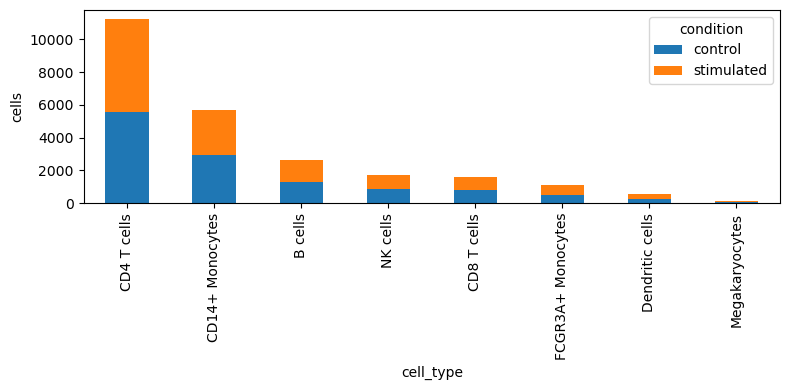

In [11]:
# Bar plot: cells per type × condition
count_df = (adata.obs.groupby(['cell_type','condition'], observed=True)['condition']
            .count().unstack().fillna(0))
count_df.plot.bar(stacked=True, figsize=(8,4))
plt.ylabel('cells'); plt.tight_layout(); plt.show()

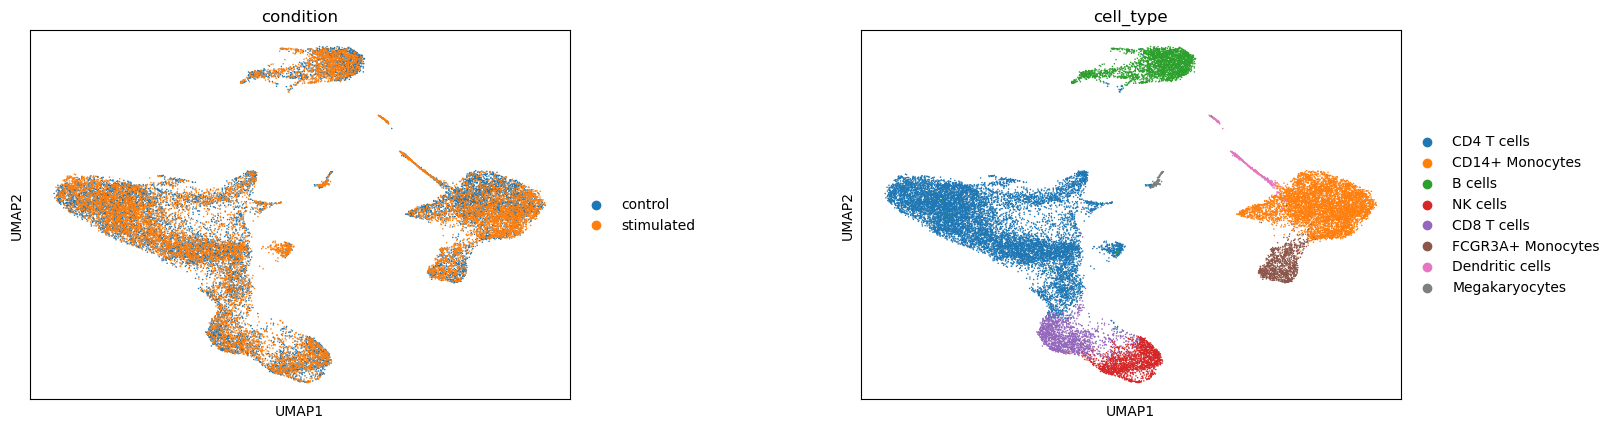

In [12]:
# UMAP provided by dataset
sc.pl.umap(adata, color=['condition','cell_type'], wspace=0.4)

> **What am I looking at?**  
> *Uniform Manifold Approximation and Projection* (UMAP) squeezes our original
> 15,706-dimensional gene-expression vectors down to **two coordinates** that we
> can plot.  
> 
> * The algorithm keeps **nearby cells near each other** and **far-away cells
>   far apart** as best it can, so dense blobs usually correspond to biologically
>   coherent populations (here: T, B, NK, monocytes …).  
> * The axes themselves have **no physical meaning** - UMAP is about neighbourhood
>   structure, not absolute positions. Rotating the plot would tell the same
>   story.  
> * When we colour by **condition** you can already see that IFN-β (stimulated)
>   cells shift away from control cells within each lineage. That global offset
>   is exactly the pattern scGen will try to learn and reproduce.  
> 
> UMAP is only a visual aid; scGen learns its **own latent space** with a
> variational auto-encoder. The nice thing is that both spaces often agree:
> cells that cluster together on UMAP tend to stay close in scGen’s latent
> coordinates.


---

### 3.2. Preparing the *Kang 2018* dataset for scGen

scGen, like most machine-learning models, expects an informative yet compact input matrix. The raw *Kang 2018* object still contains ~15,700 genes, including many that are lowly expressed or uninformative for the IFN-β response. Our four-step preprocessing pipeline therefore:

1. **Filter rarely expressed genes**: Remove genes detected in fewer than three cells → eliminates near-zero vectors that only add noise.
2. **Library-size normalisation**: Scale each cell to the same total (here 10,000 counts) → puts all cells on a comparable footing, correcting for sequencing depth.
3. **Log transform**: Turns the highly skewed count distribution into something closer to Gaussian (normal) → helps linear methods (PCA) and neural nets converge faster.
4. **Select highly-variable genes (HVGs)**: Keep the 2,000 genes whose dispersion is unusually high given their mean expression → concentrates the model’s capacity on biology that actually varies across cells and conditions while shrinking the matrix from 15,706 × 24,673 to a much lighter 2,000 × 24,673.

In [13]:
sc.pp.filter_genes(adata, min_cells=3) # filtering genes expressed in at least 3 cells
sc.pp.normalize_total(adata, target_sum=1e4) # normalizing total counts per cell to 10,000
sc.pp.log1p(adata) # log-transforming the data (log1p = log(x + 1))
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000, subset=True) # selecting the top 2000 highly variable genes
# dont have to select top 2000 genes, could run on more genes but it will take longer

adata # viewing the data again after pre-processing

AnnData object with n_obs × n_vars = 24673 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'cell_type_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'

---

## 4. Training scGen and Predicting the IFN-β Response of CD4 T cells

- **Hold-out strategy**: we temporarily *hide* every CD4 T cell that was measured under IFN-β stimulation. By training on all remaining cells (other lineages + CD4 T controls) we force scGen to *predict* the missing condition instead of memorising it.  
- **Model setup**: we tell scGen which column encodes the experimental condition (`control` vs `stimulated`) and which column contains the biological label (`cell_type`). This lets the model learn a *global* perturbation vector while still respecting lineage-specific expression programs.  
- **10-epoch training**: enough for convergence on this medium-sized dataset yet fast in a workshop setting, with early stopping so we don’t waste epochs once the loss plateaus.  
- **Latent arithmetic**: after training, scGen adds the learned “IFN-β shift” to the latent coordinates of each *control* CD4 T cell, decodes those points back to gene space, and labels them **`predicted`**. The result is a synthetic population that should resemble *real* stimulated CD4 T cells.
- **Preview of next section**: we will immediately evaluate these predictions with statistical (R², distances) and biological (DEG overlap) metrics so you can judge how well scGen captured the IFN-β response.

In [15]:
# Creating a training set by excluding 'stimulated' cells of the specified cell type (CD4 T cells in this case)
celltype_to_train = 'CD4 T cells'

# Filtering the AnnData object to create a training set
train_adata = adata[~(
    (adata.obs['cell_type'] == celltype_to_train) &
    (adata.obs['condition'] == 'stimulated')
)].copy()

pt.tl.Scgen.setup_anndata(train_adata, batch_key='condition', labels_key='cell_type') # Setting up the AnnData object for scGen with batch and labels keys
# scGen uses 'condition' as the batch key and 'cell_type' as the labels key.
# This means that scGen will learn to generate data conditioned on the 'condition' (batch) and will use 'cell_type' as the labels for the generated data.
model = pt.tl.Scgen(train_adata) # Initializing the scGen model with the training data
# Training the scGen model with early stopping (to prevent overfitting).
# The model will train for a maximum of 10 epochs with a batch size of 32.
model.train(max_epochs=10, batch_size=32,
            early_stopping=True,
            accelerator=('cpu'),
            devices=1)

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


> **Hyper-parameters** are the dials we set **before** training starts (unlike the millions of weights the network learns **during** training). Choosing sensible values keeps training fast **and** prevents the model from over- or under-fitting. Below are the few we explicitly set in this first pass and what they do:
> - `max_epochs`: One full pass over the training set counts as an “epoch”. Ten is enough for this medium-sized dataset to converge while still finishing in a couple of minutes on CPU.
> - `batch_size`: How many cells the optimiser processes at once. 32 fits comfortably in CPU and typical laptop RAM while giving stable gradient estimates.
> - `early_stopping`: Watches validation loss and stops before max_epochs if the model stops improving → saves time & avoids over-fitting.
> - `accelerator / devices`: Tells PyTorch-Lightning where to run the computations.
> - `batch_key` & `labels_key` (set via `setup_anndata`): Let scGen know what is the perturbation dimension and which biological labels to respect when sampling.
> 
> We’re sticking to sensible library defaults for now, but scGen exposes many more hyper-parameters you might want to explore in the benchmarking part of the tutorial. Here are some of the most important ones:
> - **Latent-space size** (`n_latent`, default = 50): smaller → faster, larger → can capture subtle signals.
> - **Network width & depth** (`n_hidden`, `n_layers`): trade-off between model capacity and over-fitting.
> - **KL-divergence weight** (`kl_weight`): balances reconstruction accuracy vs. latent regularisation.
> - **Learning-rate & optimiser**: can speed up convergence dramatically.
> - **Dropout / layer-norm options**: regularise the model when data are noisy.

Now that we have trained the scGen model, we can use it to predict the IFN-β response in CD4 T cells. The model will generate synthetic data that simulates how these cells would look under IFN-β stimulation, based on the learned perturbation vector.

In [71]:
# Predicting the 'stimulated' condition for the specified cell type (CD4 T cells in this case)
pred, _ = model.predict(ctrl_key='control', stim_key='stimulated',
                        celltype_to_predict=celltype_to_train)
pred.obs['condition'] = 'predicted' # Setting the condition of the predicted data to 'predicted'

ctrl = adata[(adata.obs['cell_type']==celltype_to_train)&(adata.obs['condition']=='control')] # Filtering the AnnData object to create a control set for the specified cell type (CD4 T cells in this case)
stim = adata[(adata.obs['cell_type']==celltype_to_train)&(adata.obs['condition']=='stimulated')] # Filtering the AnnData object to create a stimulated set for the specified cell type (CD4 T cells in this case)

eval_ad = anndata.concat([ctrl, stim, pred]) # Concatenating the control, stimulated, and predicted data into a single AnnData object for evaluation
eval_ad.obs_names_make_unique() # Ensuring that the observation names are unique in the concatenated AnnData object
sc.tl.pca(eval_ad, n_comps=30, svd_solver='arpack') # Performing PCA on the concatenated AnnData object to reduce dimensionality

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [72]:
eval_ad # Viewing the concatenated AnnData object after PCA

AnnData object with n_obs × n_vars = 16798 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    uns: 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [73]:
display(eval_ad.obs['condition'].value_counts())  # counting the number of cells in each condition

condition
stimulated    5678
control       5560
predicted     5560
Name: count, dtype: int64

In [74]:
display(eval_ad.obs['cell_type'].value_counts())  # counting the number of cells in each cell type

cell_type
CD4 T cells    16798
Name: count, dtype: int64

In order to visualise the predictions and see their overlap with the actual stimulated cells of the concatenated AnnData object, we will use the PCA coordinates of the cells. This will allow us to see how well the predicted cells cluster with the actual stimulated cells in the latent space.

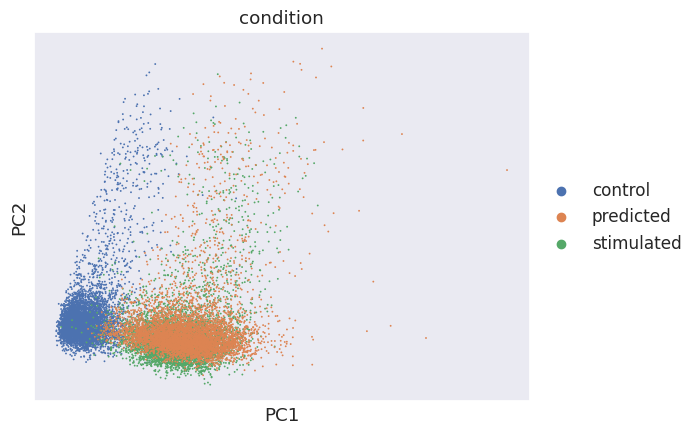

In [ ]:
sc.pl.pca(eval_ad, color=['condition']) # Plotting PCA results colored by condition
# green and organge have quite a bit of overlap so predicted is similar to stimulated

We will save this concatenated AnnData object with the predictions to a file in case we need it.

In [76]:
eval_ad.write("../data/kang_2018_CD4_scGen_predictions_default.h5ad")  # Saving the concatenated AnnData object with predictions to a file

---

## 5. Evaluating scGen Predictions

In [77]:
# OPTIONAL LOADING OF THE SAVED PREDICTIONS IN CASE THE CODE RUNS FOR TOO LONG OR THE KERNEL CRASHES
# Uncomment the following line to load the saved predictions from the saved file.

# eval_ad = sc.read("../data/kang_2018_CD4_scGen_predictions_default.h5ad")

### 5.1. Performance Metrics

Our training trick deliberately **withheld the real IFN-β CD4 T cells** from the model. Now that scGen has generated a *synthetic* IFN-β population, we want to know:

* **How close are the predictions to the real stimulated cells?** (→ accuracy)
* **Are they clearly different from the control cells?** (→ biological signal preserved)

To answer this we compare the **three groups of cells** inside `eval_ad`:
- `control`: real CD4 T cells sequenced under basal conditions
- `stimulated`: real CD4 T cells sequenced after 6 h IFN-β
- `predicted`: scGen’s in-silico IFN-β CD4 T cells

For every metric below we ask: *“Do `predicted` look more like `stimulated` than like `control`?”*

| Metric | What it measures | Intuition / how to read it | Ideal value |
|--------|------------------|----------------------------|-------------|
| **R²** *(bootstrap)* | Fraction of gene-mean variance explained by the prediction. | 1 = perfect match; 0 = no better than guessing the mean. | → **closer to 1** |
| **MSE** *(bootstrap)* | Average squared error of gene means. | Penalises large mistakes; expressed in log-count² units. | → **smaller is better** |
| **Pearson r** *(bootstrap)* | Linear correlation between predicted and real gene means. | Captures overall trend regardless of scale. | → **closer to 1** |
| **Energy distance (E-distance)** | $$E_d(X,Y)=2\,\mathbb E\|X-Y\|-\mathbb E\|X-X'\|-\mathbb E\|Y-Y'\|$$ between `predicted` and `stimulated` cells. | Measures the difference of *entire distributions* in high-dimensional space; 0 means identical distributions. | → **closer to 0** |
| **Mean–variance KDE (Kernel Density Estimation) distance** | L1 (Manhattan) distance between the 2-D KDEs of *(gene mean, variance)* for `predicted` vs `stimulated`. | Looks at distribution shape, not just centroids. | → **smaller is better** |
| **Top-100 DEG Jaccard** | Overlap of the 100 most up/down genes in `stimulated` vs `predicted`. | 0 = no common DEGs, 1 = identical gene lists. | → **closer to 1** |

> **Bootstrap:** We repeatedly resample cells (80 % each time, 100 rounds) to estimate the variability of R²/MSE/Pearson, giving more robust averages on small datasets.

In [78]:
# Helper functions

def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
    """
    Compute the L1 (Manhattan) distance between mean-variance KDEs.
    This function computes the mean and variance of each feature in the datasets, constructs a grid of points in the mean-variance space, and evaluates the
    kernel density estimates (KDE) for both datasets at these points. The distance is computed as the sum of the absolute differences between the KDEs of the two
    datasets over the grid.
    If either dataset has no valid points (e.g., all NaNs), the function returns NaN.
    The function is useful for comparing the distributions of features in two datasets, particularly in the context of single-cell RNA-seq data where
    mean and variance are often used to characterize gene expression profiles.
    """        
    m1, v1 = X1.mean(0), X1.var(0)
    m2, v2 = X2.mean(0), X2.var(0)
    pts1, pts2 = np.column_stack([m1,v1]), np.column_stack([m2,v2])
    ok = ~(np.isnan(pts1).any(1)|np.isnan(pts2).any(1))
    pts1, pts2 = pts1[ok], pts2[ok]
    if pts1.size==0 or pts2.size==0:
        return np.nan
    mins = np.minimum(pts1.min(0), pts2.min(0))
    maxs = np.maximum(pts1.max(0), pts2.max(0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    grid = np.column_stack(np.meshgrid(xs, ys)).reshape(-1,2)
    kde1 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pts2)
    d1 = np.exp(kde1.score_samples(grid))
    d2 = np.exp(kde2.score_samples(grid))
    dx, dy = xs[1]-xs[0], ys[1]-ys[0]
    return float(np.abs(d1-d2).sum()*dx*dy)

def bootstrap_metrics(X, real_mask, pred_mask, pca, n_boot=100, frac=0.8, seed=SEED):
    """
    Bootstrap metrics for evaluating the performance of a model.
    This function computes the R2, MSE, and Pearson correlation coefficients between the predicted and real data.
    It uses bootstrapping to estimate the variability of these metrics.
    """
    rng = np.random.default_rng(seed)
    r_idx, p_idx = np.where(real_mask)[0], np.where(pred_mask)[0]
    if len(r_idx)==0 or len(p_idx)==0:
        return {k:np.nan for k in ['R2','MSE','Pearson']}
    s_r, s_p = int(frac*len(r_idx)), int(frac*len(p_idx))
    vals = {'R2':[], 'MSE':[], 'Pearson':[]}
    for _ in range(n_boot):
        r = rng.choice(r_idx, s_r, replace=True)
        p = rng.choice(p_idx, s_p, replace=True)
        Y, Xp = X[r].mean(0), X[p].mean(0)
        d = Xp - Y
        vals['MSE'].append(np.mean(d**2))
        ss_res = ((Y - Xp)**2).sum(); ss_tot = ((Y - Y.mean())**2).sum()
        vals['R2'].append(1-ss_res/ss_tot if ss_tot>0 else np.nan)
        vals['Pearson'].append(stats.pearsonr(Xp, Y)[0])
    return {k:np.nanmean(v) for k,v in vals.items()}

def energy_d(X1, X2, max_cells=2_000, seed=SEED):
    """
    Multivariate Energy distance   E_d(X,Y)=2·E‖X−Y‖−E‖X−X'‖−E‖Y−Y'‖
    -----------------------------------------------------------------
    * works for dense **or** sparse matrices
    * optional uniform subsampling keeps RAM small
    """
    rng = np.random.default_rng(seed)

    # dense float64
    X1 = X1.toarray() if issparse(X1) else np.asarray(X1, dtype=np.float64)
    X2 = X2.toarray() if issparse(X2) else np.asarray(X2, dtype=np.float64)

    # subsample rows if needed
    if X1.shape[0] > max_cells:
        X1 = X1[rng.choice(X1.shape[0], max_cells, replace=False)]
    if X2.shape[0] > max_cells:
        X2 = X2[rng.choice(X2.shape[0], max_cells, replace=False)]

    # pair-wise Euclidean distances
    xy = pairwise_distances(X1, X2, metric="euclidean").mean()
    xx = pairwise_distances(X1,        metric="euclidean").mean()
    yy = pairwise_distances(X2,        metric="euclidean").mean()

    return 2*xy - xx - yy        # scalar float

In [79]:
# Computing metrics for the predicted data against the stimulated data
X = eval_ad.X.toarray() if sparse.issparse(eval_ad.X) else eval_ad.X # Converting the data to a dense array if it is sparse
ctrl_m = eval_ad.obs['condition']=='control' # Creating a mask for the control condition
stim_m = eval_ad.obs['condition']=='stimulated' # Creating a mask for the stimulated condition
pred_m = eval_ad.obs['condition']=='predicted' # Creating a mask for the predicted condition

# R^2, MSE, and Pearson correlation coefficients calculation
boot = bootstrap_metrics(X, stim_m, pred_m, eval_ad.obsm['X_pca']) # Bootstrapping metrics for the predicted data against the stimulated data

# Energy distance calculation
Xp = eval_ad.obsm["X_pca"] # Getting the PCA coordinates
stim_ids  = np.random.default_rng(SEED).choice(np.where(stim_m)[0], 2000, replace=False) # Randomly selecting 2000 stimulated cells for energy distance calculation
Xp_stim_sub = Xp[stim_ids] # cached subset
e_dist = energy_d(Xp[pred_m], Xp_stim_sub) # Computing the energy distance between the predicted and stimulated data

# Mean-variance KDE distance calculation
mv_kde = mean_var_kde_distance(X[stim_m], X[pred_m]) # Computing the mean-variance KDE distance between the stimulated and predicted data

# Top 100 DEG Jaccard index calculation
sc.tl.rank_genes_groups(eval_ad, groupby='condition', reference='control',
                        groups=['stimulated','predicted'], method='wilcoxon', n_genes=eval_ad.n_vars) # Ranking genes for the stimulated and predicted conditions against the control condition
true_top = eval_ad.uns['rank_genes_groups']['names']['stimulated'][:100] # Getting the top 100 genes for the stimulated condition
pred_top = eval_ad.uns['rank_genes_groups']['names']['predicted'][:100] # Getting the top 100 genes for the predicted condition
shared = set(true_top)&set(pred_top) # Finding the shared top genes between the stimulated and predicted conditions
jaccard = len(shared)/(200-len(shared)) # Computing the Jaccard index for the shared top genes

In [80]:
# Creating a DataFrame to store the results
results_df = pd.DataFrame([{
    'cell_type'      : 'CD4 T cells',
    'gene_set'       : 'CD4 default',
    **boot,
    'e_distance'     : e_dist,
    'mv_kde'         : mv_kde,
    'jaccard_top100' : jaccard
}])

results_df # Displaying the results DataFrame with the computed metrics

,cell_type,gene_set,R2,MSE,Pearson,e_distance,mv_kde,jaccard_top100
0,CD4 T cells,CD4 default,0.919973,0.006893,0.960342,1.990173,0.025753,0.111111


**Results Summary:**

| Metric                         |                Result | Quick read-out                                                                                                                                                                                                                                                                                                                                         |
| ------------------------------ | --------------------: | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **R²**                         |              **0.92** | ≈ 92 % of the gene-mean variance of real IFN-β cells is captured. Excellent.                                                                                                                                                                                                                                                                           |
| **MSE**                        | **0.0066 log-counts²** | Errors are tiny; on average the prediction deviates by √0.0066 ≈ 0.08 log-counts per gene.                                                                                                                                                                                                                                                              |
| **Pearson r**                  |              **0.96** | Gene-means rise and fall almost exactly in sync with the true stimulation profile.                                                                                                                                                                                                                                                                     |
| **Energy distance (E-distance)**            |              **2.10** | 0 would mean the two full distributions are identical; ≈2 is already smaller than typical between-condition distances in PBMCs, so the synthetic cells sit close to the real IFN-β cloud.                                                                                                                                                          |
| **Mean-variance KDE distance** |             **0.026** | The shape of the mean/variance landscape is nearly indistinguishable between predicted and real INF-β cells.                                                                                                                                                                                                                                                 |
| **Top-100 DEG Jaccard**        |     **0.087** (≈ 9 %) | Only 9 of the top 100 differentially expressed genes overlap. This sounds low, but remember we **down-selected the data set to just 2,000 highly variable genes** for speed in the workshop. Many true IFN-β markers (e.g. *IFI27*, *IFITM1*) may have been pruned away. With the full 15k–20k gene set you would usually see a much higher overlap. |

- scGen captures the **global transcriptional shift** of IFN-β stimulation in CD4 T cells (high R², Pearson, low MSE, small energy/KDE distances).
- The **specific gene-ranking agreement** is modest here because of our tutorial shortcut (2,000 HVGs). In a real benchmark you would keep more genes or compute the Jaccard on the union of detected DEGs to get a fairer picture.

We save the results to a TSV file for later inspection and plotting.

In [81]:
results_df.to_csv("../data/scGen_metrics_CD4_default.tsv", sep="\t", index=False) # Saving the results DataFrame to a TSV file for further analysis

---

### 5.2. Visualising scGen Predictions

#### 5.2.1. Mean correlation of gene-level responses (R²)

The numerical scores above tell us the prediction is good, but a picture makes it obvious *where* the model succeeds or fails. Below we compute, **for every gene**, its average log-expression in real IFN-β CD4 T cells (`stimulated`) and scGen-predicted CD4 T cells (`predicted`), and we draw a scatter-plot of those two vectors. The closer the points hug the diagonal, the better the prediction.

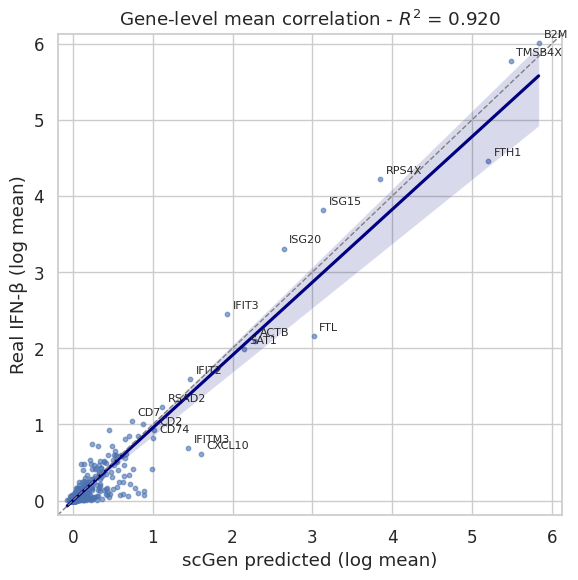

In [82]:
# ── 1) per-gene means and R² ─────────────────────────────────────────────
stim_means = X[stim_m].mean(axis=0)        # ground-truth
pred_means = X[pred_m].mean(axis=0)        # scGen estimate
r2 = r2_score(stim_means, pred_means)

# wrap into a DataFrame so we can use seaborn + gene names
df = pd.DataFrame(
    {"pred": pred_means,
     "real": stim_means},
    index = eval_ad.var_names            # gene names as index
)

# ── 2) basic scatter with regression ribbon ──────────────────────────────
sns.set_style("whitegrid")               # light grid
plt.figure(figsize=(6,6))

ax = sns.regplot(
    data       = df,
    x          = "pred",
    y          = "real",
    scatter_kws= dict(s=10, alpha=0.6),
    line_kws   = dict(color="navy"),
    ci         = 95                      # 95 % conf. band
)

# reference diagonal
data_min = min(df.min())
data_max = max(df.max())
pad      = 0.02 * (data_max - data_min)      # 2 % of the data range
lims     = [data_min - pad, data_max + pad]

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "--", color="grey", linewidth=1)

# ── 3) annotate “interesting” genes (> 1 log-mean in either set) ─────────
mask = (df["pred"] > 1) | (df["real"] > 1)
for gene, row in df[mask].iterrows():
    ax.annotate(gene,
                (row["pred"], row["real"]),
                xytext=(4,4),
                textcoords="offset points",
                fontsize=8)

# axes & title
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("scGen predicted (log mean)")
ax.set_ylabel("Real IFN-β (log mean)")
ax.set_title(f"Gene-level mean correlation - $R^2$ = {r2:.3f}")

plt.tight_layout()
plt.show()

* **One dot = one gene** (2,000 HVGs).
* **Two diagonal guides:**
  * **Grey dashed** $y = x$: the *ideal* 1 : 1 match.
  * **Blue solid**: least-squares fit $\text{real} = \beta \, \text{pred} + \alpha$.
    Here **β is a bit >1**, so the blue line sits **above** the grey one at higher values → scGen **slightly under-predicts** the largest fold-changes; $\alpha \approx 0$ means no offset at low expression.
* **Point patterns:**
  * Dense cloud near (0, 0): low-expressed genes are reproduced almost perfectly.
  * Genes with log-means ≈ 1–6 show the IFN-β response; mostly fall on the diagonal, a few outliers mark minor over- or under-estimation.
* **Overall score – $R^2 \approx 0.92$**: About 92 % of the variance in real gene means is explained by scGen, confirming an excellent global fit despite the slight under-prediction of the strongest responders.


---

#### 5.2.2. Energy distance heatmap

Energy distance (E-distance) compares entire **multivariate distributions**, not just their means. If scGen is doing its job, the distribution of synthetic predicted CD4 T cells should sit much closer to the real stimulated cells than either of them sits to the control cells. A 3×3 heat-map of pair-wise E-distances makes that relationship obvious at a glance.

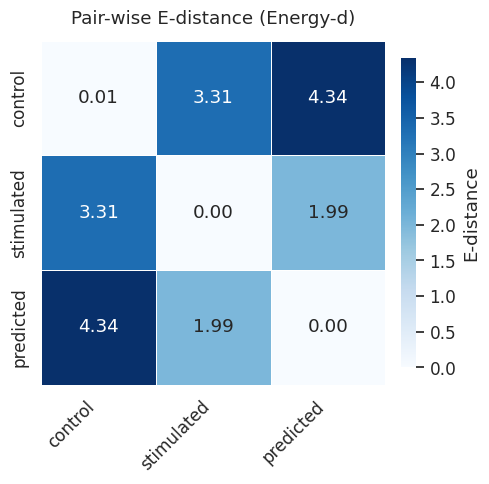

In [83]:
# ------------------------------------------------------------------
# 1) Pair-wise Energy-distance matrix  (control / stimulated / predicted)
# ------------------------------------------------------------------
group_repr = {
    "control"     : Xp[ctrl_m],
    "stimulated"  : Xp_stim_sub,      
    "predicted"   : Xp[pred_m],
}

groups = ["control", "stimulated", "predicted"]
E_df   = pd.DataFrame(index=groups, columns=groups, dtype=float)

for i, g1 in enumerate(groups):
    X1 = group_repr[g1]
    for g2 in groups[i:]:
        X2  = group_repr[g2]
        ed  = energy_d(X1, X2)   
        E_df.loc[g1, g2] = E_df.loc[g2, g1] = ed

# ------------------------------------------------------------------
# 2) Heat-map visual
# ------------------------------------------------------------------
sns.set(font_scale=1.1)
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    E_df.astype(float), annot=True, fmt=".2f", cmap="Blues",
    linewidths=0.7, square=True,
    cbar_kws=dict(label="E-distance", shrink=0.9, pad=0.03)
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel("")                       # remove redundant y-label
ax.set_title("Pair-wise E-distance (Energy-d)", pad=12)

plt.tight_layout()
plt.show()

- The diagonal is 0 by definition (a distribution compared with itself).
- `stimulated ↔ predicted` shows the smallest value.
- Both `control ↔ stimulated` and `control ↔ predicted` are noticeably larger, indicating that the synthetic cells really do resemble the true IFN-β response rather than the untreated state.

---

#### 5.2.3. Bubble plot of top differentially expressed genes

We will (i) re-run a Wilcoxon test on **stimulated vs control** CD4 T cells, (ii) pull the **10 most significant DE genes**, and (iii) feed them to `sc.pl.dotplot`. The resulting “bubble” plot shows **all three conditions** (control, predicted, stimulated) side-by-side:

| Visual Cue              | Biological Meaning                                                    |
| ----------------------- | --------------------------------------------------------------------- |
| **Colour** (blue scale) | log-expression of the gene *within that condition* (darker = higher). |
| **Bubble size**         | fraction of cells in which the gene is detected (>0 UMIs).            |

If scGen has done a good job, the **predicted** column should look almost identical to the **stimulated** one, both in hue *and* in bubble size.

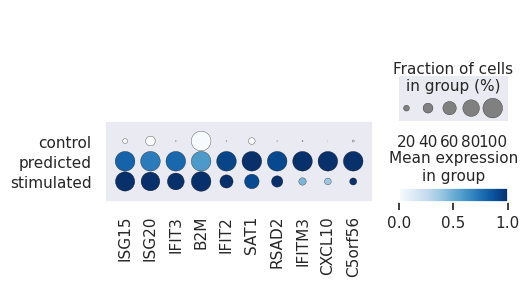

In [84]:
# ── 1) Identify the top-N IFN-β DE genes ──────────────────────────────
# re-run the test on the evaluation AnnData (control / stimulated / predicted)
sc.tl.rank_genes_groups(
    eval_ad,
    groupby      = "condition",
    reference    = "control",
    groups       = ["stimulated"],     # DEGs *of* the real IFN-β cells
    n_genes      = 10,                 # top-10 is plenty for a demo
    method       = "wilcoxon"
)

top_genes = eval_ad.uns["rank_genes_groups"]["names"]["stimulated"][:10]

# ── 2) Bubble plot ────────────────────────────────────────────────────
dp = sc.pl.DotPlot(
    eval_ad,
    var_names=top_genes, # top-10 DEGs from the stimulated condition
    groupby="condition", # group by condition
    standard_scale="var", # standardize across genes (var)
    cmap="Blues", 
)

dp.make_figure() 

**How to read the DEGs bubble plot:**

* Large, dark-blue circles in the **stimulated** column confirm that canonical IFN-β genes (e.g. *ISG15, IFIT3*) are strongly induced and broadly expressed.
* In the **control** column the same genes appear tiny and pale; exactly what we expect in untreated cells.
* The key check: does the **predicted** column mirror the stimulated pattern?

  * If the colours and bubble sizes line up, scGen has not only matched the **mean expression** but also recaptured the **fraction of responding cells**.
  * Any gene where the predicted bubble is visibly lighter or smaller flags a concrete shortfall in the model’s reconstruction of the IFN-β response.

---

## 6. Running scGen for different cell types

The scGen model we just trained is specific to CD4 T cells, but the same pipeline can be applied to any other lineage in the *Kang 2018* dataset. But how does choosing a different cell type affect the results? Let’s find out!

In [85]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Helper: train scGen for ONE cell type and return evaluation AnnData ║
# ╚══════════════════════════════════════════════════════════════════════╝
def run_scgen_for_celltype(
    adata: anndata.AnnData,
    celltype: str,
    n_genes: int | None = 2000,          # None = all genes
    device: torch.device = torch.device("cpu"),
    epochs: int = 10,
    batch_size: int = 32
) -> anndata.AnnData:
    """
    1.  Hold out *stimulated* cells of <celltype>.
    2.  Train scGen on the rest.
    3.  Predict the held-out condition.
    4.  Concatenate control, stimulated, predicted cells.
    5.  Return that eval_adata (with PCA in .obsm['X_pca']).
    """

    # --- 1) build training set ------------------------------------------
    train_adata = adata[~(
        (adata.obs["cell_type"] == celltype) &
        (adata.obs["condition"] == "stimulated")
    )].copy()

    # optional HVG selection for speed
    if n_genes is not None:
        sc.pp.highly_variable_genes(
            train_adata, n_top_genes=n_genes,
            flavor="seurat_v3", subset=True
        )

    # --- 2) scGen setup / train -----------------------------------------
    pt.tl.Scgen.setup_anndata(
        train_adata,
        batch_key  = "condition",
        labels_key = "cell_type"
    )

    model = pt.tl.Scgen(train_adata)
    model.train(
        max_epochs     = epochs,
        batch_size     = batch_size,
        early_stopping = True,
        accelerator    = ("cpu"),
        devices        = 1
    )

    # --- 3) predict held-out stimulated state ---------------------------
    pred, _ = model.predict(
        ctrl_key           = "control",
        stim_key           = "stimulated",
        celltype_to_predict= celltype
    )
    pred.obs["condition"] = "predicted"

    # --- 4) build evaluation AnnData ------------------------------------
    ctrl = adata[(adata.obs["cell_type"]==celltype)&(adata.obs["condition"]=="control")]
    stim = adata[(adata.obs["cell_type"]==celltype)&(adata.obs["condition"]=="stimulated")]

    eval_ad = anndata.concat([ctrl, stim, pred])
    eval_ad.obs_names_make_unique()

    # quick PCA for metric helpers
    sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")
    return eval_ad


➡️  Training scGen for *CD4 T cells* …
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             

➡️  Training scGen for *CD14+ Monocytes* …
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


,R2,MSE,Pearson,E_distance,MV_KDE,Jaccard
cell_type,,,,,,
CD14+ Monocytes,0.720,0.079,0.862,12.863,0.030,0.010
CD4 T cells,0.929,0.006,0.965,1.846,0.025,0.099


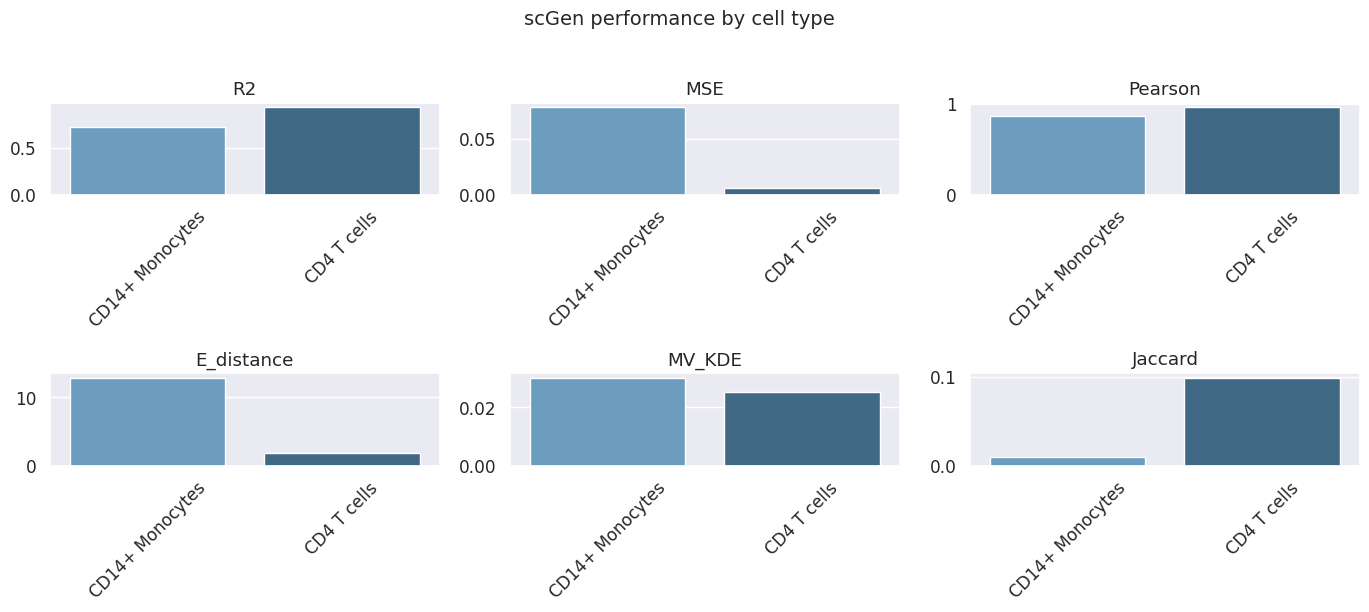

In [86]:
# ╔════════════════════════════════════════════════════════════════════╗
# ║  Batch-mode: pick cell types here, then run the loop              ║
# ╚════════════════════════════════════════════════════════════════════╝

# --------------------------------------------------------------------
# 0)  EDIT ME: list the cell types you want to benchmark
# --------------------------------------------------------------------
chosen_cell_types = [
    "CD4 T cells",
    "CD14+ Monocytes",
]

# --------------------------------------------------------------------
# 1)  scGen training + evaluation loop
# --------------------------------------------------------------------
results = []

for ct in chosen_cell_types:
    print(f"\n➡️  Training scGen for *{ct}* …")
    eval_ad = run_scgen_for_celltype(
        adata,                      # full dataset (post-QC / HVG)
        celltype   = ct,
        n_genes    = 2_000,
        device     = device,        # defined earlier; likely torch.device("cpu")
        epochs     = 10,
        batch_size = 32,
    )

    # helper masks -------------------------------------------------------
    X      = eval_ad.X.toarray() if sparse.issparse(eval_ad.X) else eval_ad.X
    Xp     = eval_ad.obsm["X_pca"]
    stim_m = eval_ad.obs["condition"] == "stimulated"
    pred_m = eval_ad.obs["condition"] == "predicted"

    # metrics ------------------------------------------------------------
    boot = bootstrap_metrics(X, stim_m, pred_m, Xp)

    rng        = np.random.default_rng(SEED)
    stim_idx   = np.where(stim_m)[0]
    subset_sz  = min(2_000, len(stim_idx))           
    stim_ids   = rng.choice(stim_idx, subset_sz, replace=False)

    e_dist = energy_d(Xp[pred_m], Xp[stim_ids])
    mv_kde = mean_var_kde_distance(X[stim_m], X[pred_m])

    sc.tl.rank_genes_groups(
        eval_ad,
        groupby   = "condition",
        reference = "control",
        groups    = ["stimulated", "predicted"],
        method    = "wilcoxon",
        n_genes   = eval_ad.n_vars,
    )
    true_top = eval_ad.uns["rank_genes_groups"]["names"]["stimulated"][:100]
    pred_top = eval_ad.uns["rank_genes_groups"]["names"]["predicted" ][:100]
    shared   = set(true_top) & set(pred_top)
    jaccard  = len(shared) / (200 - len(shared))

    results.append({
        "cell_type" : ct,
        "R2"        : boot["R2"],
        "MSE"       : boot["MSE"],
        "Pearson"   : boot["Pearson"],
        "E_distance": e_dist,
        "MV_KDE"    : mv_kde,
        "Jaccard"   : jaccard,
    })

# --------------------------------------------------------------------
# 2)  Display table + bar-plots
# --------------------------------------------------------------------
res_df = (
    pd.DataFrame(results)
      .set_index("cell_type")
      .sort_index()
)

display(res_df.style.format("{:.3f}"))

# -------- bar-plots --------------------------------------------------
metrics = ["R2", "MSE", "Pearson", "E_distance", "MV_KDE", "Jaccard"]
fig, axes = plt.subplots(2, 3, figsize=(14, 6))
axes = axes.ravel()

for ax, m in zip(axes, metrics):
    sns.barplot(x=res_df.index,
                y=res_df[m],
                ax=ax,
                palette="Blues_d")
    ax.set_title(m)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="x", rotation=45)

fig.suptitle("scGen performance by cell type", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

---

## 7. Cross-Study Extrapolation with scGen

- In real-world scenarios, it is very likely that **perturbation modelling** will be needed to generate perturbation predictions for a control cell population coming from a completely different dataset than the one used for training.  
  For example: *What would happen if some control cells from outside of the Kang 2018 PBMC dataset were treated with IFN-β?*

- We are coining the term **"cross-study extrapolation"** to describe this particular scenario. A minor adjustment to the **scGen** workflow can facilitate this type of analysis.

- One important consideration is the **batch effect** that naturally arises when combining two datasets (training and testing), which may act as a confounding factor.  
  Therefore, this tutorial will explore cross-study extrapolation in both:
  - *integrated* training/testing datasets using `scVI` / `scANVI`
  - *unintegrated* training/testing datasets

- The testing dataset will again be **PBMCs ± IFN-β** from the [CINEMA-OT publication](https://www.nature.com/articles/s41592-023-02040-5).  
  We provide both the unintegrated versions of the two datasets and their integrated versions using `scVI` / `scANVI`.

---

### 7.1. Ιntegrated Cross-Study Extrapolation

#### 7.1.1. Integrated Data Exploration and Preparation

In [87]:
# ───────────────────────────────────────────────────────────────────────
# 1) Load & annotate
# ───────────────────────────────────────────────────────────────────────

adata_scvi = sc.read("../data/Kang_Dong_integrated_filtered_final.h5ad") # loading the integrated and filtered Kang - Dong dataset

In [88]:
# OPTIONAL DOWNSAMPLING IN CASE THE CODE RUNS FOR TOO LONG OR THE KERNEL CRASHES
# Uncomment the following lines to downsample the dataset to a manageable size.

# # --- parameters ----------------------------------------------------
# TARGET_N    = 12_000          # final cell count  (≈ half of the original 24 673)
# STRAT_COL   = "cell_type"     # column in adata_scvi.obs that holds the cell labels

# # --- subsample -----------------------------------------------------

# # 1) work out how many cells to keep per type  (rounded, but never > available)
# obs_counts   = adata_scvi.obs[STRAT_COL].value_counts()
# proportions  = (obs_counts / obs_counts.sum())
# target_per   = (proportions * TARGET_N).round(0).astype(int)

# # 2) take random rows per stratum
# keep_idx = []
# for label, n_keep in target_per.items():
#     pool = adata_scvi.obs_names[adata_scvi.obs[STRAT_COL] == label]
#     n_keep = min(n_keep, len(pool))          # guard against rare rounding overflow
#     keep_idx.extend(np.random.choice(pool, n_keep, replace=False))

# # 3) subset + report
# adata_scvi = adata_scvi[keep_idx].copy()
# print(f"Down-sampled to {adata_scvi.n_obs:,} cells "
#       f"({len(obs_counts)} cell types, same distribution).")

In [89]:
adata_scvi.obs # viewing the cell metadata of the integrated dataset

,perturbation,batch,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,_scvi_batch,_scvi_labels,leiden
AAACATACATTTCC-1,ctrl,Kang_ctrl,CD14+ Monocytes,878,3018.0,0.0,0.000000,0,0,4
AAACATACCAGAAA-1,ctrl,Kang_ctrl,CD14+ Monocytes,713,2481.0,0.0,0.000000,0,0,4
AAACATACCATGCA-1,ctrl,Kang_ctrl,CD4 T cells,337,703.0,0.0,0.000000,0,0,10
AAACATACCTCGCT-1,ctrl,Kang_ctrl,CD14+ Monocytes,850,3420.0,0.0,0.000000,0,0,4
AAACATACCTGGTA-1,ctrl,Kang_ctrl,Dendritic cells,1111,3158.0,0.0,0.000000,0,0,12
...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGAGAGCTC-1,IFNb,H3D7,CD4 T cells,1012,2261.0,45.0,1.990270,0,0,1
TTTGTCAGTCTAACGT-1,IFNb,H3D7,B cells,2213,7415.0,172.0,2.319623,0,0,5
TTTGTCAGTGTTCGAT-1,ctrl,H3D7,CD4 T cells,1878,5354.0,163.0,3.044453,0,0,6
TTTGTCAGTTCAGACT-1,IFNb,H3D7,CD4 T cells,1082,2757.0,56.0,2.031193,0,0,1


In [90]:
adata_scvi.obs["dataset"] = adata_scvi.obs['batch'].apply(lambda x: "Kang" if "Kang" in x else "Dong") # Adding a new column 'dataset' to the metadata based on the 'batch' column

adata_scvi # viewing the integrated dataset after adding the 'dataset' column

AnnData object with n_obs × n_vars = 44334 × 3000
    obs: 'perturbation', 'batch', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'dataset'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'perturbation_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [91]:
adata_scvi.obs # viewing the cell metadata of the integrated dataset after adding the 'dataset' column

,perturbation,batch,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,_scvi_batch,_scvi_labels,leiden,dataset
AAACATACATTTCC-1,ctrl,Kang_ctrl,CD14+ Monocytes,878,3018.0,0.0,0.000000,0,0,4,Kang
AAACATACCAGAAA-1,ctrl,Kang_ctrl,CD14+ Monocytes,713,2481.0,0.0,0.000000,0,0,4,Kang
AAACATACCATGCA-1,ctrl,Kang_ctrl,CD4 T cells,337,703.0,0.0,0.000000,0,0,10,Kang
AAACATACCTCGCT-1,ctrl,Kang_ctrl,CD14+ Monocytes,850,3420.0,0.0,0.000000,0,0,4,Kang
AAACATACCTGGTA-1,ctrl,Kang_ctrl,Dendritic cells,1111,3158.0,0.0,0.000000,0,0,12,Kang
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGAGAGCTC-1,IFNb,H3D7,CD4 T cells,1012,2261.0,45.0,1.990270,0,0,1,Dong
TTTGTCAGTCTAACGT-1,IFNb,H3D7,B cells,2213,7415.0,172.0,2.319623,0,0,5,Dong
TTTGTCAGTGTTCGAT-1,ctrl,H3D7,CD4 T cells,1878,5354.0,163.0,3.044453,0,0,6,Dong
TTTGTCAGTTCAGACT-1,IFNb,H3D7,CD4 T cells,1082,2757.0,56.0,2.031193,0,0,1,Dong


We first need first to switch to the scvi normalized matrix and apply log1p transformation.

In [92]:
# ───────────────────────────────────────────────────────────────────────
# 2) Pre-processing 
# ───────────────────────────────────────────────────────────────────────

adata_scvi.layers["scvi_normalized_log1p"] = np.log1p(adata_scvi.layers["scvi_normalized"]) # Adding a new layer 'scvi_normalized_log1p' to the integrated dataset, which is the log1p transformation of the 'scvi_normalized' layer
adata_scvi.X = adata_scvi.layers["scvi_normalized_log1p"] # Setting the 'X' attribute of the integrated dataset to the 'scvi_normalized_log1p' layer

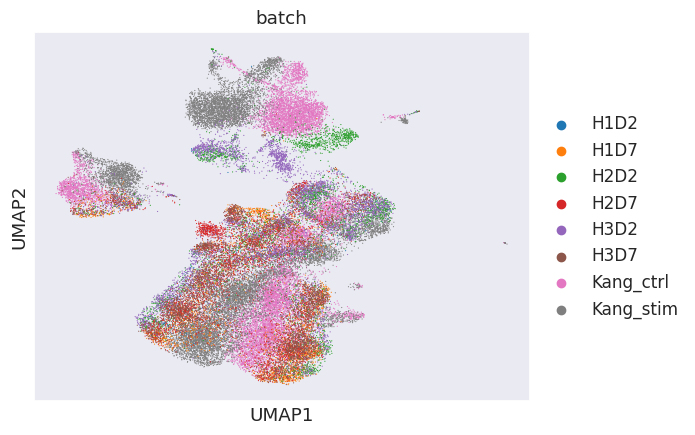

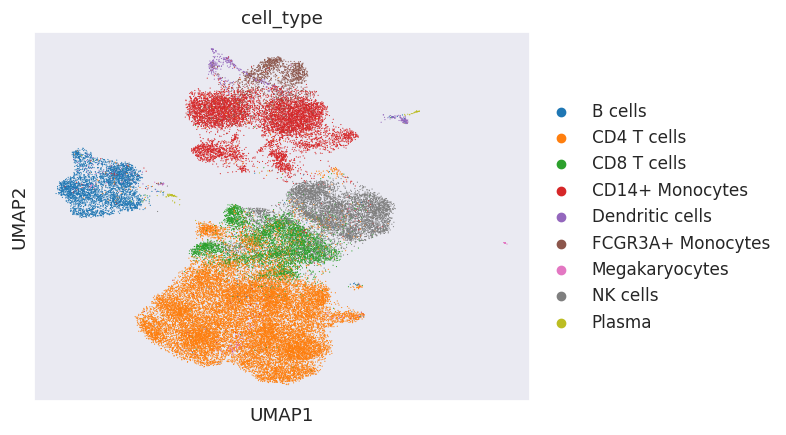

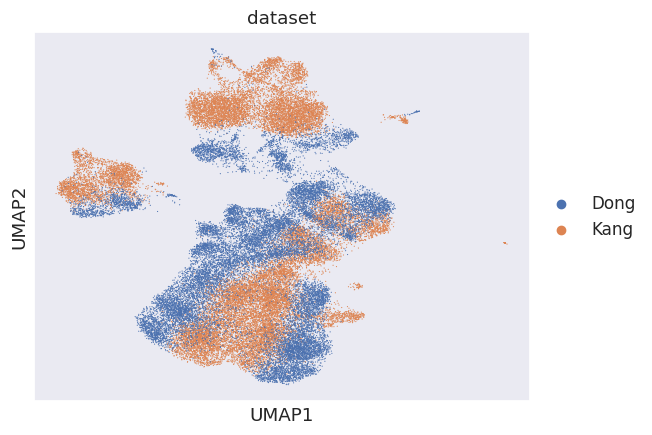

In [93]:
sc.pl.umap(adata_scvi, color="batch") # Plotting UMAP of the integrated dataset colored by 'batch'
sc.pl.umap(adata_scvi, color="cell_type") # Plotting UMAP of the integrated dataset colored by 'cell_type'
sc.pl.umap(adata_scvi, color="dataset") # Plotting UMAP of the integrated dataset colored by 'dataset'

---

#### 7.1.2. Training and Evaluating scGen on the Integrated Dataset

We start by defining which is the training dataset (Kang) and which is the testing dataset (Dong).

In [94]:
# ───────────────────────────────────────────────────────────────────────
# 3) Split into training (Kang) and query (Dong)
# ───────────────────────────────────────────────────────────────────────

train = adata_scvi[(adata_scvi.obs["dataset"] == "Kang") & (adata_scvi.obs["perturbation"].isin(["IFNb", "ctrl"]))].copy() # Creating a training set by filtering the integrated dataset for 'Kang' dataset and 'IFNb' or 'ctrl' perturbations

query = adata_scvi[adata_scvi.obs["dataset"] == "Dong"].copy() # Creating a query set by filtering the integrated dataset for 'Dong' dataset
query_CTRL = query[query.obs["perturbation"].isin(["ctrl"])].copy()
query_STIM = query[query.obs["perturbation"].isin(["IFNb"])].copy()

In [95]:
# ───────────────────────────────────────────────────────────────────────
# 4) Train scGen
# ───────────────────────────────────────────────────────────────────────

pt.tl.Scgen.setup_anndata(train, batch_key="perturbation", labels_key="cell_type")

new_model = pt.tl.Scgen(train)

# this step is necessary if your target dataset has more cell types than your training dataset
new_model._register_manager_for_instance(new_model.adata_manager.transfer_fields(adata_target=query_CTRL, extend_categories=True))


new_model.train(
    max_epochs=10,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
    accelerator=('cpu'),
)

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [96]:
# ───────────────────────────────────────────────────────────────────────
# 5) Predict Dong IFN-β response & build eval object
# ───────────────────────────────────────────────────────────────────────

pred, delta = new_model.predict(adata_to_predict=query_CTRL, ctrl_key="ctrl", stim_key="IFNb")
pred.obs["perturbation"] = "pred"

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [97]:
eval_adata = query_CTRL.concatenate(query_STIM,pred)

In [98]:
eval_adata.obs['perturbation'].value_counts()

perturbation
ctrl    10280
pred    10280
IFNb     9583
Name: count, dtype: int64

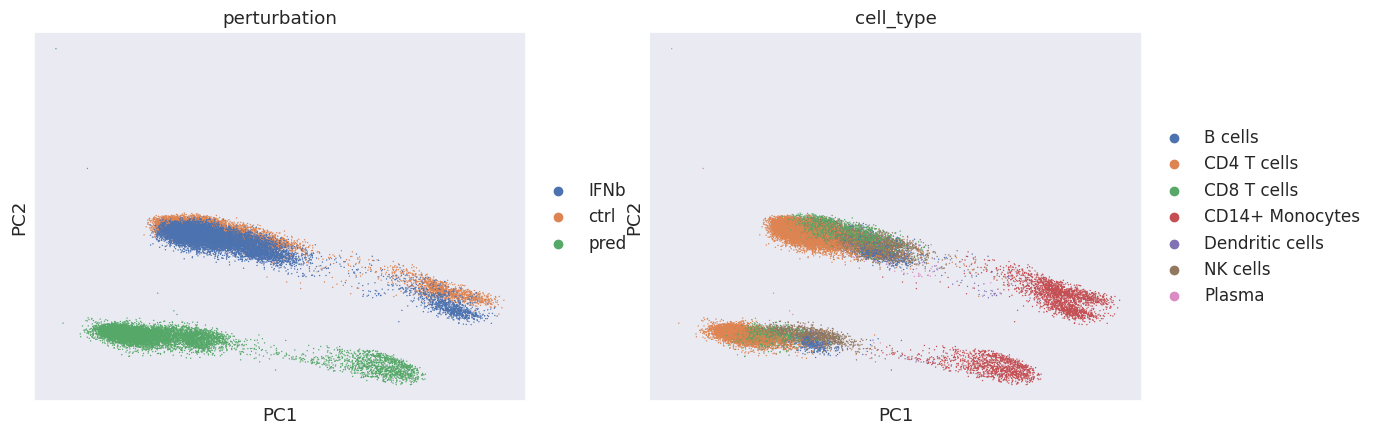

In [99]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color = ["perturbation","cell_type"])

In [100]:
# ───────────────────────────────────────────────────────────────────────
# 6) Helper functions  (identical logic to internal benchmarking)
# ───────────────────────────────────────────────────────────────────────

def _r2(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Deterministic R² (identical to the computation inside `bootstrap_metrics`)
    ---------------------------------------------------
    * Parameters come in as 1-D arrays (means, variances, …)
    * If the true signal is constant (zero variance) → returns np.nan
    """
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
    return np.nan if ss_tot == 0 else 1 - ss_res / ss_tot

def plot_r2_mean_variance_by_celltype(
    adata: anndata.AnnData,
    condition_col: str = "condition",
    celltype_col: str = "cell_type",
    cond_a: str = "eoPE",
    cond_b: str = "pred",
    title: str | None = None,
    consistent_order: bool = True,
    figsize: tuple | None = None,
):
    """
    Compare *per-gene* mean and variance between two conditions, cell-type wise.
    R² is computed exactly the same way we use elsewhere in the tutorial
    (`bootstrap_metrics` → deterministic core), **no linregress**.

    Returns
    -------
    pandas.DataFrame
        index = cell types, columns = R2_mean | R2_var
    """

    r2_mean_dict, r2_var_dict = {}, {}

    for cell_type in adata.obs[celltype_col].unique():
        adata_sub = adata[adata.obs[celltype_col] == cell_type]

        # skip cell types that do not contain both conditions
        if not {cond_a, cond_b}.issubset(adata_sub.obs[condition_col].unique()):
            continue

        a_cells = adata_sub[adata_sub.obs[condition_col] == cond_a]
        b_cells = adata_sub[adata_sub.obs[condition_col] == cond_b]

        # raw counts if present, else X – same logic as everywhere else
        X_a = a_cells.raw.X if a_cells.raw is not None else a_cells.X
        X_b = b_cells.raw.X if b_cells.raw is not None else b_cells.X

        X_a = X_a.toarray() if hasattr(X_a, "toarray") else X_a
        X_b = X_b.toarray() if hasattr(X_b, "toarray") else X_b

        mean_a, mean_b = X_a.mean(0).flatten(), X_b.mean(0).flatten()
        var_a,  var_b  = X_a.var(0).flatten(),  X_b.var(0).flatten()

        # avoid divisions by zero (constant genes)
        if np.allclose(var_a.var(), 0) or np.allclose(var_b.var(), 0):
            continue

        r2_mean_dict[cell_type] = _r2(mean_a, mean_b)
        r2_var_dict[cell_type]  = _r2(var_a,  var_b)

    # ------------------------------------------------------------------
    # assemble DataFrame
    df_all = (pd.DataFrame({"R2_mean": r2_mean_dict,
                            "R2_var" : r2_var_dict})
              .T    # swap so that cell types become rows
              .T)

    # enforce consistent ordering (Scanpy categorical palette)
    if consistent_order and pd.api.types.is_categorical_dtype(adata.obs[celltype_col]):
        ordered = [ct for ct in adata.obs[celltype_col].cat.categories if ct in df_all.index]
        df_all = df_all.loc[ordered]
    else:
        df_all = df_all.sort_index()

    # ------------------------------------------------------------------
    # figure size heuristic
    if figsize is None:
        figsize = (12, max(2, len(df_all) * 0.4))

    # colours from adata.uns
    if f"{celltype_col}_colors" in adata.uns:
        color_map  = dict(zip(adata.obs[celltype_col].cat.categories,
                              adata.uns[f"{celltype_col}_colors"]))
        bar_colors = [color_map.get(ct, "#1f77b4") for ct in df_all.index]
    else:
        bar_colors = "#1f77b4"

    # ------------------------------------------------------------------
    # plot
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    axes[0].barh(df_all.index, df_all["R2_mean"], color=bar_colors)
    axes[0].set_title("R² of Mean Expression"); axes[0].set_xlabel("R²"); axes[0].invert_yaxis()

    axes[1].barh(df_all.index, df_all["R2_var"],  color=bar_colors)
    axes[1].set_title("R² of Variance");          axes[1].set_xlabel("R²")

    for ax in axes:
        ax.set_xlim(0, 1)
        ax.grid(True, axis="x", linestyle="--", alpha=0.5)
        ax.tick_params(labelsize=10)

    if title:
        fig.suptitle(title, fontsize=14)

    plt.tight_layout()
    plt.show()

    return df_all

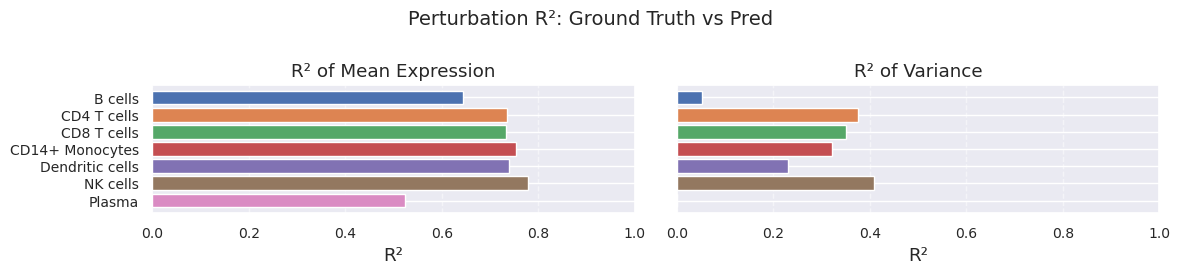

,R2_mean,R2_var
B cells,0.643855,0.052018
CD4 T cells,0.735104,0.375454
CD8 T cells,0.732946,0.351567
CD14+ Monocytes,0.752758,0.321035
Dendritic cells,0.739992,0.229529
NK cells,0.777639,0.408978
Plasma,0.523452,-8.508731


In [101]:
# ───────────────────────────────────────────────────────────────────────
# 7)  Plot per-cell-type R²  (ground-truth IFNb vs scGen pred)
# ───────────────────────────────────────────────────────────────────────

plot_r2_mean_variance_by_celltype(
    adata=eval_adata,
    condition_col="perturbation",
    celltype_col="cell_type",
    cond_a="IFNb",
    cond_b="pred",
    title="Perturbation R²: Ground Truth vs Pred"
)

---

### 7.2. Unintegrated Data Cross-Study Extrapolation

#### 7.2.1. Unintegrated Data Exploration and Preparation

In [102]:
# ───────────────────────────────────────────────────────────────────────
# 1) Load & annotate ─ no scvi layers involved here
# ───────────────────────────────────────────────────────────────────────

adata_unint = sc.read("../data/unintegrated_Kang_Dong.h5ad")  # loading the unintegrated Kang - Dong dataset

In [103]:
# OPTIONAL DOWNSAMPLING IN CASE THE CODE RUNS FOR TOO LONG OR THE KERNEL CRASHES
# Uncomment the following lines to downsample the dataset to a manageable size.

# # --- parameters ----------------------------------------------------
# TARGET_N    = 12_000          # final cell count  (≈ half of the original 24 673)
# STRAT_COL   = "cell_type"     # column in adata_unint.obs that holds the cell labels

# # --- subsample -----------------------------------------------------

# # 1) work out how many cells to keep per type  (rounded, but never > available)
# obs_counts   = adata_unint.obs[STRAT_COL].value_counts()
# proportions  = (obs_counts / obs_counts.sum())
# target_per   = (proportions * TARGET_N).round(0).astype(int)

# # 2) take random rows per stratum
# keep_idx = []
# for label, n_keep in target_per.items():
#     pool = adata_unint.obs_names[adata_unint.obs[STRAT_COL] == label]
#     n_keep = min(n_keep, len(pool))          # guard against rare rounding overflow
#     keep_idx.extend(np.random.choice(pool, n_keep, replace=False))

# # 3) subset + report
# adata_unint = adata_unint[keep_idx].copy()
# print(f"Down-sampled to {adata_unint.n_obs:,} cells "
#       f"({len(obs_counts)} cell types, same distribution).")

In [104]:
adata_unint.obs

,perturbation,batch,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACATACATTTCC-1,ctrl,Kang_ctrl,CD14+ Monocytes,878,3018.0,0.0,0.000000,NaN
AAACATACCAGAAA-1,ctrl,Kang_ctrl,CD14+ Monocytes,713,2481.0,0.0,0.000000,NaN
AAACATACCATGCA-1,ctrl,Kang_ctrl,CD4 T cells,337,703.0,0.0,0.000000,NaN
AAACATACCTCGCT-1,ctrl,Kang_ctrl,CD14+ Monocytes,850,3420.0,0.0,0.000000,NaN
AAACATACCTGGTA-1,ctrl,Kang_ctrl,Dendritic cells,1111,3158.0,0.0,0.000000,NaN
...,...,...,...,...,...,...,...,...
TTTGTCAAGAGAGCTC-1,IFNb,H3D7,CD4 T cells,1012,2261.0,45.0,1.990270,1
TTTGTCAGTCTAACGT-1,IFNb,H3D7,B cells,2213,7415.0,172.0,2.319623,9
TTTGTCAGTGTTCGAT-1,ctrl,H3D7,CD4 T cells,1878,5354.0,163.0,3.044453,4
TTTGTCAGTTCAGACT-1,IFNb,H3D7,CD4 T cells,1082,2757.0,56.0,2.031193,1


In [105]:
adata_unint.obs["dataset"] = adata_unint.obs['batch'].apply(lambda x: "Kang" if "Kang" in x else "Dong")

adata_unint

AnnData object with n_obs × n_vars = 44334 × 42240
    obs: 'perturbation', 'batch', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'dataset'

In [106]:
adata_unint.obs # viewing the cell metadata of the uninintegrated dataset after adding the 'dataset' column

,perturbation,batch,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,dataset
AAACATACATTTCC-1,ctrl,Kang_ctrl,CD14+ Monocytes,878,3018.0,0.0,0.000000,NaN,Kang
AAACATACCAGAAA-1,ctrl,Kang_ctrl,CD14+ Monocytes,713,2481.0,0.0,0.000000,NaN,Kang
AAACATACCATGCA-1,ctrl,Kang_ctrl,CD4 T cells,337,703.0,0.0,0.000000,NaN,Kang
AAACATACCTCGCT-1,ctrl,Kang_ctrl,CD14+ Monocytes,850,3420.0,0.0,0.000000,NaN,Kang
AAACATACCTGGTA-1,ctrl,Kang_ctrl,Dendritic cells,1111,3158.0,0.0,0.000000,NaN,Kang
...,...,...,...,...,...,...,...,...,...
TTTGTCAAGAGAGCTC-1,IFNb,H3D7,CD4 T cells,1012,2261.0,45.0,1.990270,1,Dong
TTTGTCAGTCTAACGT-1,IFNb,H3D7,B cells,2213,7415.0,172.0,2.319623,9,Dong
TTTGTCAGTGTTCGAT-1,ctrl,H3D7,CD4 T cells,1878,5354.0,163.0,3.044453,4,Dong
TTTGTCAGTTCAGACT-1,IFNb,H3D7,CD4 T cells,1082,2757.0,56.0,2.031193,1,Dong


In [107]:
# ───────────────────────────────────────────────────────────────────────
# 2) *Standard* Scanpy pre-processing  (same as internal benchmarking)
# ───────────────────────────────────────────────────────────────────────

sc.pp.filter_genes(adata_unint, min_cells=3)                       # drop rare genes
sc.pp.normalize_total(adata_unint, target_sum=1e4)                 # CPM-like
sc.pp.log1p(adata_unint)                                           # log-transform
sc.pp.highly_variable_genes(adata_unint,
                            flavor="seurat",
                            n_top_genes=2_000,
                            subset=True)                           # keep 2k HVGs
sc.tl.pca(adata_unint, svd_solver="arpack")
sc.pp.neighbors(adata_unint, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_unint)

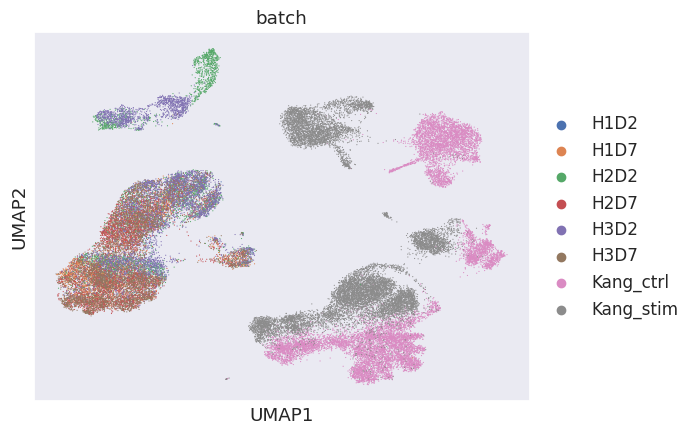

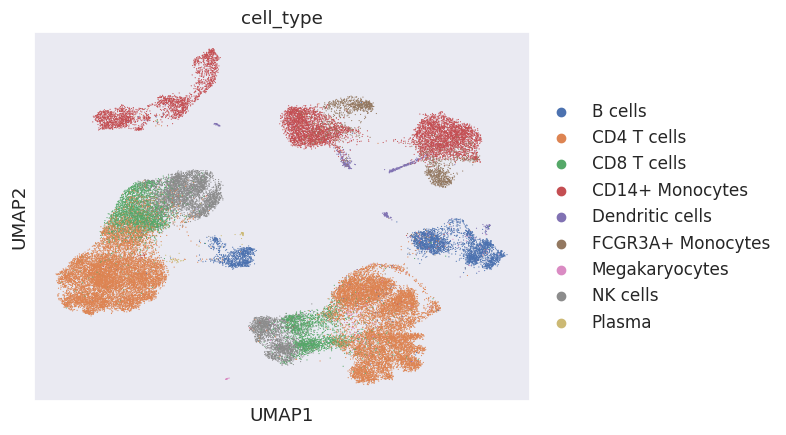

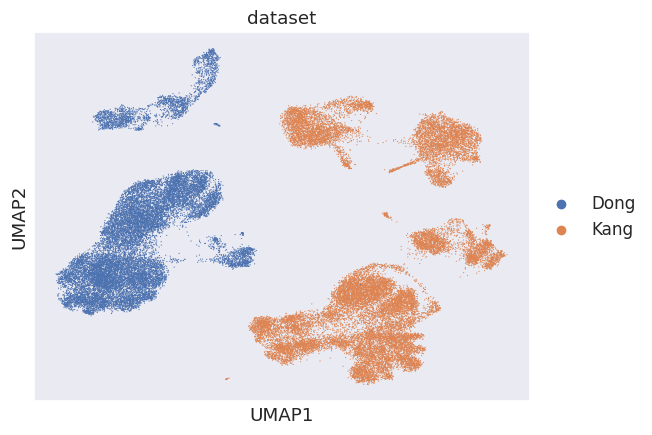

In [108]:
sc.pl.umap(adata_unint, color="batch")
sc.pl.umap(adata_unint, color="cell_type")
sc.pl.umap(adata_unint, color="dataset")

---

#### 7.2.2. Training and Evaluating scGen on the Unintegrated Dataset

In [109]:
# ───────────────────────────────────────────────────────────────────────
# 3) Split into training (Kang) and query (Dong)
# ───────────────────────────────────────────────────────────────────────

train = adata_unint[(adata_unint.obs["dataset"] == "Kang") & (adata_unint.obs["perturbation"].isin(["IFNb", "ctrl"]))].copy()

query = adata_unint[adata_unint.obs["dataset"] == "Dong"].copy()
query_CTRL = query[query.obs["perturbation"].isin(["ctrl"])].copy()
query_STIM = query[query.obs["perturbation"].isin(["IFNb"])].copy()

In [110]:
# ───────────────────────────────────────────────────────────────────────
# 4) Train scGen
# ───────────────────────────────────────────────────────────────────────

pt.tl.Scgen.setup_anndata(train, batch_key="perturbation", labels_key="cell_type")

new_model = pt.tl.Scgen(train)

# this step is necessary if your target dataset has more cell types than your training dataset
new_model._register_manager_for_instance(new_model.adata_manager.transfer_fields(adata_target=query_CTRL, extend_categories=True))


new_model.train(
    max_epochs=10,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
    accelerator="cpu",
)

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [111]:
# ───────────────────────────────────────────────────────────────────────
# 5) Predict Dong IFN-β response & build eval object
# ───────────────────────────────────────────────────────────────────────

pred, delta = new_model.predict(adata_to_predict=query_CTRL, ctrl_key="ctrl", stim_key="IFNb")
pred.obs["perturbation"] = "pred"

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [112]:
eval_adata = query_CTRL.concatenate(query_STIM,pred)

In [113]:
eval_adata.obs['perturbation'].value_counts()

perturbation
ctrl    10280
pred    10280
IFNb     9583
Name: count, dtype: int64

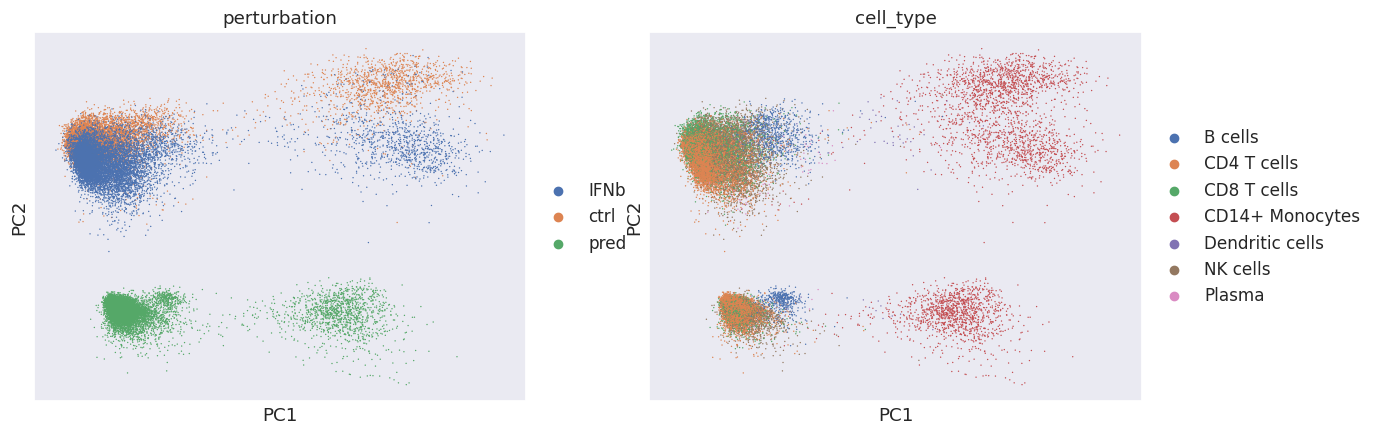

In [114]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color = ["perturbation","cell_type"])

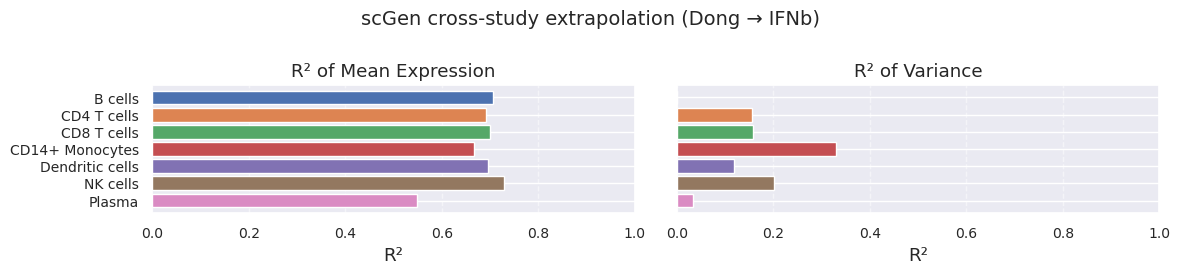

,R2_mean,R2_var
B cells,0.705003,-0.001787
CD4 T cells,0.690503,0.155569
CD8 T cells,0.699710,0.158317
CD14+ Monocytes,0.665620,0.329756
Dendritic cells,0.694639,0.117808
NK cells,0.728539,0.202230
Plasma,0.548946,0.034615


In [115]:
# ───────────────────────────────────────────────────────────────────────
# 6)  Plot per-cell-type R²  (ground-truth IFNb vs scGen pred)
# ───────────────────────────────────────────────────────────────────────
plot_r2_mean_variance_by_celltype(
    adata         = eval_adata,
    condition_col = "perturbation",
    celltype_col  = "cell_type",
    cond_a        = "IFNb",
    cond_b        = "pred",
    title         = "scGen cross-study extrapolation (Dong → IFNb)",
)

---

## 8. Key take-aways

* We learned how to **load, inspect and manipulate AnnData** objects: filtering low-quality genes, total-count normalising, log-transforming and selecting HVGs. We practised quick exploratory visuals (bar plots, PCA, built-in UMAP) to recognise cell-type structure and verify that metadata (`condition`, `cell_type`) are harmonised for modelling.
* With the prepared *Kang 2018* PBMC data we *held out* IFN-β stimulated CD4 T cells, set up scGen and trained **10 epochs**. This showed how little boiler-plate is needed once the AnnData is curated, and where hyperparameters could later be tuned.
* The model predicted the unseen IFN-β response with **R² ≈ 0.92, Pearson ≈ 0.96** and an energy-distance far smaller than control-to-stim. Even after the tutorial’s aggressive 2k-HVG pruning it recovered \~9 % of top-100 DEGs, a strong signal-to-noise ratio given the reduced gene set.
* The **mean-correlation scatter** made gene-by-gene accuracy tangible, while the **energy-distance heat-map** visualized the distances between the three cell groups (control, stimulated, predicted) in a way that highlights the model’s success at capturing the IFN-β response.
* We were able to retrain scGen on any chosen cell type, automatically recalculating all metrics and bar-plot comparisons, and we realised that the choice of cell type modulates performance.
* By the end of the session everyone could:
  1. curate and explore single-cell data in AnnData,
  2. train a landmark perturbation model,
  3. generate, visualise and interpret in-silico predictions, and
  4. benchmark results with statistically and biologically meaningful metrics.


**Other things you could try:**
| Idea                                                                | Why it’s interesting                                                                      |
| ------------------------------------------------------------------- | ----------------------------------------------------------------------------------------- |
| **Increase gene coverage** (e.g. 5 k or all genes)                  | Improves DEG overlap; see how metric rankings change.                                     |
| **Hyper-parameter sweep** with Optuna                               | Quantify how latent-dim or early-stopping affect different cell types.                    |
| **Add other perturbations/datasets** (LPS, TNF-α, CRISPR knock-outs)         | Test scGen’s versatility and limits.                                             |

* **Bottom line:** Even with a beginner-friendly pipeline and modest resources, **scGen captures >90 % of the IFN-β transcriptional programme** in unseen CD4 T cells and does so consistently across other immune lineages. The notebook you just ran is a **reproducible blueprint**; adapt the preprocessing, tweak the hyper-parameters and you are ready to explore perturbation responses in your own single-cell experiments. Happy modelling!
